# **HighResMIP model analysis for West Africa drought study**

In [59]:
import xarray as xr; xr.set_options(keep_attrs = True)
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib; matplotlib.rcParams['savefig.bbox'] = "tight"    # always save with tight bounding box
import cartopy

import xclim
from xclim.core.calendar import convert_calendar

from scipy.stats import norm, gamma, gaussian_kde
import numpy as np
import glob
import re

from datetime import datetime
from datetime import timedelta

from dateutil.relativedelta import relativedelta

from IPython.display import Image

###############################################################################################################
###############################################################################################################
def decode_times(ts):
    
    # Method to manually decode times
    
    inc = re.sub(" .+", "", ts.time.units)
    startdate = pd.Timestamp(re.sub(".+since ", "", ts.time.units)+' 00:00:00.000000').to_pydatetime()
    
    if inc == "years":
        new_times = [np.datetime64(startdate + relativedelta(years = i)) for i in range(len(ts.time))]
    else:
        print("TBD: " +inc)
        return
        
    ts = ts.assign_coords(time = new_times)
    
    return ts

###############################################################################################################
## DEFINE INDICES

def jun_total(ts):
    
    jt = ts.resample(time = "MS").sum().groupby("time.month")[6]
    jt = convert_calendar(jt, "default", align_on = "date").rename("june_total")
    return jt

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

def anom_diff_ts(ts, sm = 15, t_0 = 0):
    
    # t_0 is start of year used for accumulation of anomalies (should be in middle of dry season - default is to start from beginning of calendar year)
    # sm is number of days used to smooth the anomalies (default is 15, ie day +- 7 days)
    
    # wrap year at t_0 by shifting all values forwards
    ts = ts.shift(time = -t_0)
    
    # daily anomaly wrt annual mean
    anom = ts.groupby("time.year") - ts.groupby("time.year").mean("time")
    
    # # only accumulate anomalies after t_0 (per original code)
    # anom = anom.sel(time = [d >= t_0 for d in ts.time.dt.dayofyear.values])

    # cumulative daily anomalies each year
    anom_cum = anom.groupby("time.year").cumsum()
    
    # smooth the cumulative anomalies
    anom_sm = anom_cum.rolling(time = sm, center = True).mean()
    
    # differences of smoothed anomalies
    anom_diff = anom_sm.diff("time")
    
    # push the anomalies back to have the correct dates
    anom_diff = anom_diff.shift(time = t_0)
    
    return anom_diff


def rainy_season(ts, sm = 15, t_0 = 0, longest_run = True):
        
    # get differences of smoothed anomalies
    anom_ts = anom_diff_ts(ts, sm = sm, t_0 = t_0)
    
    if longest_run:
        # only include the single longest wet period
        
        # count number of consecutive days of positive gradient in cumulative precip
        rs_length = xclim.indices.run_length.rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))
        
        # tag all days with length of period to which they belong
        rs_length = rs_length.ffill("time")
        
        # identify those days that are part of the longest wet period in each year
        rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)
    
    else:
        # include all days with positive gradient as part of wet season
        rs = anom_ts.where(anom_ts > 0)
        
    # convert calendar to Gregorian, matching dates
    rs = xclim.core.calendar.convert_calendar(rs, "default", align_on = "date")
    
    # get start & end of rainy season
    onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear.rename("rs_onset")
    ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear.rename("rs_end")
    
    # duration of rainy season
    durations = (ends - onsets).rename("rs_duration")
    
    return onsets, ends, durations

###############################################################################################################
## OTHER METHODS

def qqplot(ts, ax = None, dist = norm, marker = ".", ax_labels = True, **kwargs): 
    
    ts = ts[np.isfinite(ts)] 
    x = np.arange(0,1,1/(len(ts)+1))[1:]
    fitted = dist.fit(ts)
    
    if ax is None:
        fig, ax = plt.subplots(figsize = (5,5), dpi = 100, facecolor = "w")
        
    ax.scatter(dist.ppf(x, *fitted), sorted(ts), marker = marker, **kwargs)
    
    vmin = min([ts.min(), dist.ppf(x, *fitted).min()])
    vmax = max([ts.max(), dist.ppf(x, *fitted).max()])
    ax.plot((vmin, vmax), (vmin, vmax), ls = "--", color = "k")
    
    if ax_labels:
        ax.set_xlabel("Fitted"); ax.set_ylabel("Observed")

        
###############################################################################################################
# SAVE FOR CLIMATE EXPLORER

def cx_csv(da, fnm = None, dataset = None):
    
    # save CSV for easy import into Climate Explorer
    
    rnm = da.run.values[0]
    da = da.squeeze(drop = True)
    fnm_string = da.name+"_"+re.sub(" ", "_", rnm)
    
    if dataset is not None:
        fnm_string = dataset+"_"+fnm_string
        
    if fnm is None:
        fnm = "ts/"+fnm_string
    
    if "time" in da.dims:
        da = da.assign_coords(time = da.time.dt.year).rename(time = "#time")
    elif "year" in da.dims:
        da = da.rename(year = "#time")
    else:
        print(da.dims)
        return

    # write to csv
    fnm = re.sub(".txt", "", fnm)+".txt"
    da.to_dataframe().to_csv(fnm, sep = " ")
    
    # add a text string specifying the units (don't think format is correct here)
    if "units" in da.attrs:
        unit_string = "# "+da.name+" ["+da.units+"]"
        unit_string = "# variable ["+da.units+"]"
        ! echo "$unit_string" >> $fnm
    
    # add a line specifying the model & variable name, to be used as filename when uploading
    fnm_string = "# "+fnm_string
    ! echo "$fnm_string" >> $fnm
    
    
# def cx_netcdf(da):
    
    # save netcdf for easy import into Climate Explorer (haven't yet got this working)
    
#     zz = da.squeeze(drop = True).assign_attrs(units = "mm").expand_dims(lon = [10], lat = [15]).dropna("time", "any")
#     zz["lon"] = zz.lon.assign_attrs(units = "degrees_e")
#     zz["lat"] = zz.lat.assign_attrs(units = "degrees_n")
#     zz.to_netcdf("ts/tmp.nc")

---
## **Event definition**


### **Onset & demise of rainy season**

The method is based on that used by [Bombardi et al (2017), B017](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml), which is in turn based on an approach proposed by [Liebmann and Marengo (2001), LM01](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml#bib28). From [Bombardi et al (2017)](https://journals.ametsoc.org/view/journals/bams/100/7/bams-d-18-0177.1.xml): 

This method uses only precipitation data and calculates the timing of the rainy (or dry) season at the local scale (e.g., station or grid point) based on accumulated precipitation anomalies
$ S=\sum_{i-t_0}(p_i - \bar{p})$,  
where $p_i$ is the daily precipitation rate on day $i$, $\bar{p}$ is the long-term mean annual precipitation rate in mm/day, and $t_0$ is the starting date for the calculations.


If we want to calculate the onset date of the rainy (or demise date of the dry) season, we start the calculation of $S$ well within the dry season. Therefore, $S$ will initially assume negative values. Once the rainy season starts, there will be an inflection in $S$. The inflection point is considered the onset date of the rainy season. For regions that experience well-defined rainy seasons, the date of inflection of the $S$ curve does not depend on $t_0$, as long as $t_0$ is reasonably well defined.

- $t_0$ is defined as the date of the minimum of the first harmonic of the mean annual cycle of precipitation at each grid point. This ensures that the calculation of the onset and demise dates start half a year from the peak date of the rainy season.

- the demise date of the rainy season is defined almost exactly how we define the onset date, the only difference being that we calculate demise dates retrospectively. That is, we start the calculation of $S$ at date $t_0$ (well within the dry season) and move back in time.

-  for most years, especially in monsoonal regions, finding the inflection point is as straightforward as finding the date of minimum accumulated precipitation anomalies. Therefore, the first step consists of calculating the timing of the rainy season using the original method. However, in some years, the rainy season evolves so gradually that the dates of the minimum or maximum in the time series of accumulated precipitation anomalies are ambiguous. For such years, the algorithm tends to fail to detect the onset or demise dates or detect them too early or too late in comparison to the climatology. Therefore, after calculating the onset and demise dates, we check for outliers. Outliers are defined as cases when the onset or demise dates are below or above 1.5 times the interquartile range. Then we perform the second step, which consists of recalculating the timing of the rainy season for the cases detected as outliers. For these few cases, we determine the timing of the rainy season based on the methodology described in B017. That means that we detect the dates of onset or demise by smoothing $S$ and taking the first derivative (with respect to time) of the smoothed $S$ curve. The first day when the derivative changes sign and persists for 3 days is considered the onset (or demise) date of the rainy season. The $S$ curve is smoothed using a 1–2–1 filter passed 50 times. The smoothing in this second pass is necessary to avoid detecting false onset (or demise) dates. Finally, we check again for outliers as dates above or below 3 times (less strict than the first check) the interquartile range. If both methods fail, the data point is considered missing data. We also mask regions where the algorithm fails to detect the onset or demise dates more than 33% of the time. Note that in this work the demise dates were calculated retrospectively.

#### **Sensitivity to start of seasonal cycle**

In [2]:
# load obs, check method for identifying rainy-season days
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any")

# identify rainy season days in each time series
rs_chirps = anom_diff_ts(chirps)
rs_chirps_trunc = anom_diff_ts(chirps, t_0 = 140)

Text(0.5, 0.98, 'Rainy seasons computed from start of year or from day 140')

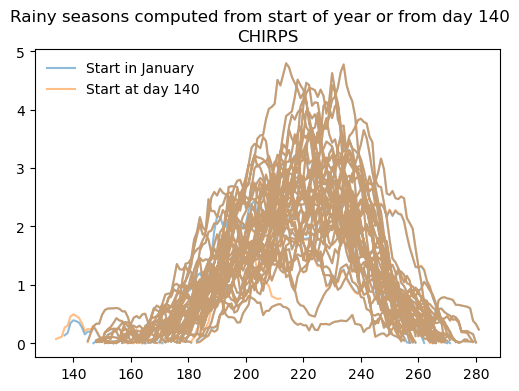

In [3]:
fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100, facecolor = "w")

axs.plot(rs_chirps.time.dt.dayofyear, rs_chirps.where(rs_chirps > 0), alpha = 0.5, ls = "-", label = "Start in January")
axs.plot(rs_chirps_trunc.time.dt.dayofyear, rs_chirps_trunc.where(rs_chirps_trunc > 0), alpha = 0.5, ls = "-", label = "Start at day 140")
axs.set_title("CHIRPS")
axs.legend(edgecolor = "w")

plt.suptitle("Rainy seasons computed from start of year or from day 140")

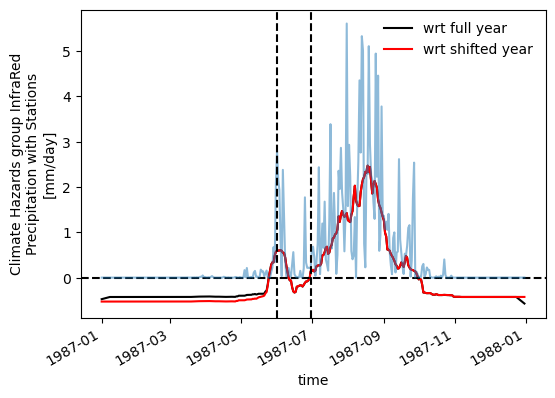

In [4]:
# example of differences in smoothed cumulative anomalies vs daily data for a single year
fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)

# 2019 & 2020 also have early/late peaks: should we 
yy = "1987"
rs_chirps.sel(time = yy).plot(ax = axs, color = "k", label = "wrt full year")
rs_chirps_trunc.sel(time = yy).plot(ax = axs, color = "red", label = "wrt shifted year")
axs.axhline(0, color = "k", ls = "--")
axs.legend(edgecolor = "w")
axs.set_title("Differences in cumulative anomaly")

chirps.sel(time = yy).plot(ax = axs, alpha = 0.5)

[axs.axvline(d, color = "k", ls = "--") for d in chirps.sel(time = [yy+"0601", yy+"0630"]).time.values]

plt.savefig("img/sensitivity-to-year-start_1-year.png")

NameError: name 't_0' is not defined

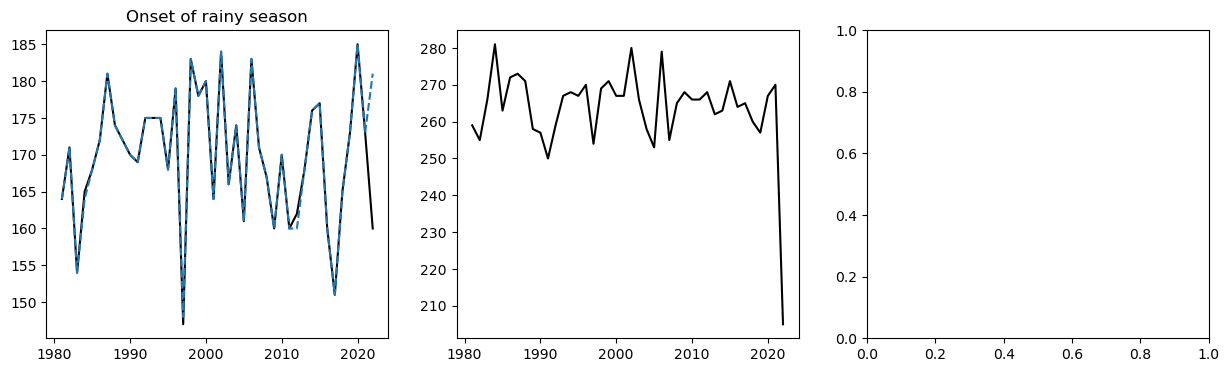

In [5]:
# sensitivity of results to changes in year start
onsets, ends, durations = rainy_season(chirps)
x_onsets, x_ends, x_durations = rainy_season(chirps, t_0 = 140)

fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4), dpi = 100, facecolor = "w")

axs[0].plot(onsets.year, onsets, color = "k")
axs[0].plot(x_onsets.year, x_onsets, ls = "--")
axs[0].set_title("Onset of rainy season")

axs[1].plot(ends.year, ends, color = "k", label = "t_0 = 0")
axs[1].plot(x_ends.year, x_ends, ls = "--", label = "t_0 = "+str(t_0))
axs[1].set_title("End of rainy season")
axs[1].legend(edgecolor = "w")

axs[2].plot(durations.year, durations, color = "k")
axs[2].plot(x_durations.year, x_durations, ls = "--")
axs[2].set_title("Duration of rainy season")

jun_doy = chirps.sel(time = ["20200601", "20200630"]).time.dt.dayofyear.values
axs[0].axhline(jun_doy[0], color = "darkred", ls = "--", alpha = 0.5, label = "June")
axs[0].axhline(jun_doy[1], color = "darkred", ls = "--", alpha = 0.5)

plt.suptitle("Sensitivity of results to changes in year start", y = 1.02, fontweight = "bold")

plt.savefig("img/sensitivity-to-year-start.png")

#### **Sensitivity to inclusion of isolated precipitation events**

In [ ]:
ts = chirps; sm = 15; t_0 = 0

# get differences of smoothed anomalies
anom_ts = anom_diff_ts(ts, sm = sm, t_0 = t_0)

# count number of consecutive days of positive gradient in cumulative precip
rs_length = xclim.indices.run_length.rle(xr.ones_like(anom_ts).where(anom_ts > 0, 0))

# tag all days with length of period to which they belong
rs_length = rs_length.ffill("time")

# identify those days that are part of the longest wet period in each year
rs = rs_length.where(rs_length.groupby("time.year") - rs_length.groupby("time.year").max() == 0)

# get start & end of rainy season
onsets = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").min().dt.dayofyear
ends = rs.time.where(rs > 0).dropna("time", "any").groupby("time.year").max().dt.dayofyear

# duration of rainy season
durations = ends - onsets

In [ ]:
yy = "1987"

fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)

chirps.sel(time = yy).plot(ax = axs, alpha = 0.5, label = "CHIRPS daily precip")
anom_ts.sel(time = yy).plot(ax = axs, color = "k", label = "Deriv of cum anomalies", alpha = 0.4)

# (rs_length.sel(time = yy) / 15).plot(ax = axs)

(xr.ones_like(rs).where(rs > 0).sel(time = yy) * -0.9).plot(color = "k")
(xr.ones_like(rs).where(rs > 0).sel(time = yy) * -0.9).plot(color = "k")

plt.plot([(anom_ts.time.where(anom_ts > 0).dropna("time", "any").groupby("time.year").min()).sel(year = int(yy)).values,
          (anom_ts.time.where(anom_ts > 0).dropna("time", "any").groupby("time.year").max()).sel(year = int(yy)).values],
         (-0.7,-0.7), color = "k", alpha = 0.4, ls = "--", label = "Non-consecutive\nrainy period")

anom_ts.where(rs > 0).sel(time = yy).plot(color = "k", label = "Consecutive\nrainy period")

axs.axhline(0, color = "k", ls = "--")
[axs.axvline(d, color = "red", ls = "--", alpha = 0.5) for d in chirps.sel(time = [yy+"0601", yy+"0630"]).time.values]

fig.legend(bbox_to_anchor = (1.3,0.6), edgecolor = "w")

plt.title("Effect of including/excluding isolated precipitation events", fontweight = "bold", y = 1.02)

plt.savefig("img/sensitivity-to-inclusion-of-storms_1-year.png")

In [ ]:
# sensitivity of results to inclusion of all wet periods
onsets, ends, durations = rainy_season(chirps)
x_onsets, x_ends, x_durations = rainy_season(chirps, longest_run = False)

fig, axs = plt.subplots(ncols = 3, nrows = 1, figsize = (15,4), dpi = 100, facecolor = "w")

axs[0].plot(onsets.year, onsets, color = "k")
axs[0].plot(x_onsets.year, x_onsets, ls = "--")
axs[0].set_title("Onset of rainy season")

axs[1].plot(ends.year, ends, color = "k", label = "Exclude isolated events")
axs[1].plot(x_ends.year, x_ends, ls = "--", label = "Include all rainy periods")
axs[1].set_title("End of rainy season")
axs[1].legend(edgecolor = "w")

axs[2].plot(durations.year, durations, color = "k")
axs[2].plot(x_durations.year, x_durations, ls = "--")
axs[2].set_title("Duration of rainy season")

jun_doy = chirps.sel(time = ["20200601", "20200630"]).time.dt.dayofyear.values
axs[0].axhline(jun_doy[0], color = "darkred", ls = "--", alpha = 0.5, label = "June")
axs[0].axhline(jun_doy[1], color = "darkred", ls = "--", alpha = 0.5)

plt.suptitle("Sensitivity of results to inclusion of isolated precipitation events vs single longest wet spell", y = 1.02, fontweight = "bold")

plt.savefig("img/sensitivity-to-inclusion-of-storms.png")

---
## **Observations**

In [ ]:
# using only CHIRPS as reference dataset
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any").sel(time = slice(None, "20211231"))

june_totals = jun_total(chirps)
onsets, ends, durations = rainy_season(chirps, sm = 15, t_0 = 0)

# save for easier reference
june_totals.to_netcdf("ts/june_totals-chirps.nc")
[eval(idx).to_netcdf("ts/season_"+idx+"-chirps.nc") for idx in ["onsets", "ends", "durations"]]

# and save as .txt for easier import into Climate Explorer
[cx_csv(da.expand_dims(run = ["chirps"])) for da in [june_totals, onsets, durations]]

#### **Check distributional assumptions**

In [ ]:
# total June precipitation
fig, axs = plt.subplots(ncols = 2, figsize = (12,4), dpi = 100, facecolor = "w")
(june_totals - june_totals.mean()).plot(ax = axs[0], label = "CHIRPS")

axs[0].axhline(0, ls = "--", color = "k")
axs[0].set_title("Time series of anomaly in June total precipitation")
axs[0].legend()

qqplot(june_totals, ax = axs[1], label = "gaussian")
qqplot(june_totals, ax = axs[1], dist = gamma, label = "gamma")

axs[1].set_title("Q-Q plot of June precip")
axs[1].legend(edgecolor = "w")

plt.suptitle("Total June precipitation over East Sahel region", fontweight = "bold", y = 1.01)

In [ ]:
fig, axs = plt.subplots(ncols = 3, nrows = 2, figsize = (15,7), dpi = 100, facecolor = "w")

axs[0,0].plot(onsets.year, onsets - onsets.mean())
axs[0,1].plot(ends.year, ends - ends.mean(), label = "From day 0")
axs[0,2].plot(durations.year, durations - durations.mean())

axs[0,0].set_title("Yearly anomaly in season onset"); axs[0,1].set_title("Yearly anomaly in season end"); axs[0,2].set_title("Yearly anomaly in season duration")
axs[0,1].legend(edgecolor = "w")
for ax in axs[0,:]: ax.axhline(0, ls = "--", color = "k")

for dist in ["norm", "gamma"]:
    
    qqplot(onsets - onsets.mean(), ax = axs[1,0], label = dist, dist = eval(dist))
    qqplot(ends - ends.mean(), ax = axs[1,1], label = dist, dist = eval(dist))
    qqplot(durations - durations.mean(), ax = axs[1,2], label = dist, dist = eval(dist))

for ax in axs[1,:]: ax.legend(edgecolor = "w")

<!-- |Source|Onset|Duration|
|------|------|------|
|Chirps|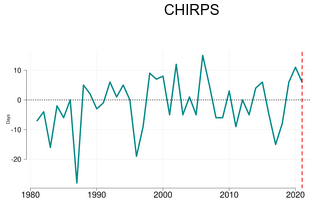      |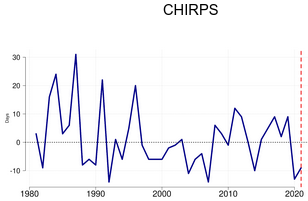     | -->
<!-- |TAMSAT|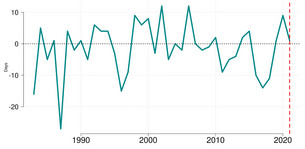     |   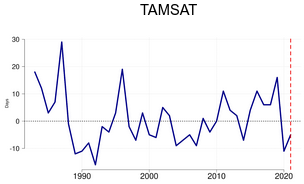     | -->

---
## **HighResMIP**

In [4]:
# create fixed colour scheme for plotting (ensures same colour per run regardless of models omitted)
fl = sorted(glob.glob("HighResMIP/pr_day_*.nc"))
mdl_cols = dict(zip(sorted([fnm.split("_")[2]+" "+fnm.split("_")[4] for fnm in fl]), matplotlib.cm.get_cmap('tab20')(np.arange(0,1,1/len(fl)))))

In [5]:
# models excluded on basis of seasonal cycle
omit = ['CNRM-CM6-1 r1i1p1f2',         # too dry, onset too late
        'CMCC-CM2-HR4 r1i1p1f1',       # too wet, onset too early
        'CMCC-CM2-VHR4 r1i1p1f1',      # too wet, onset too early
        'MPI-ESM1-2-HR r1i1p1f1',      # onset too late, peak too strong
        'MPI-ESM1-2-XR r1i1p1f1']      # onset too late, peak too strong
# EC-EARTH3P & EC-EARTH3P-HR are borderline but will wait & check parameters

### **Check seasonal cycle**

In [17]:
# load observations for reference
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any").sel(time = slice(None, "20211231"))
june_totals = jun_total(chirps)
onsets, ends, durations = rainy_season(chirps)

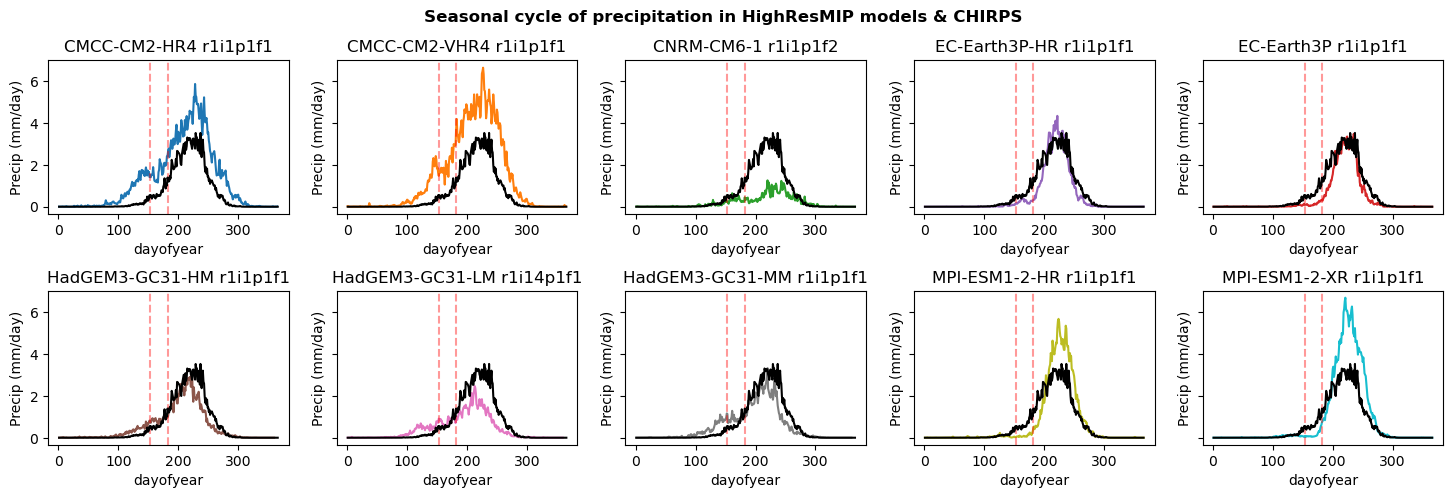

In [18]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18,5), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.5)

# chirps & tamsat are almost identical - just show chirps

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    run = fnm.split("_")[2]+" "+fnm.split("_")[4]
    
    pr = xr.open_dataset(fnm).pr.sel(time = slice("19800101", "20220101"))
    pr.groupby("time.dayofyear").mean().plot(label = run, color = mdl_cols[run], ax = ax)
    
    chirps.groupby("time.dayofyear").mean().plot(label = "CHIRPS", color = "k", zorder = 100, ax = ax)
    [ax.axvline(d, ls = "--", color = "red", alpha = 0.4) for d in chirps.sel(time = ["20000601", "20000630"]).time.dt.dayofyear.values]
    ax.set_title(run)
    
    ax.set_ylabel("Precip (mm/day)")

plt.suptitle("Seasonal cycle of precipitation in HighResMIP models & CHIRPS", fontweight = "bold")

plt.savefig("HighResMIP-seasonal-cycles.png")

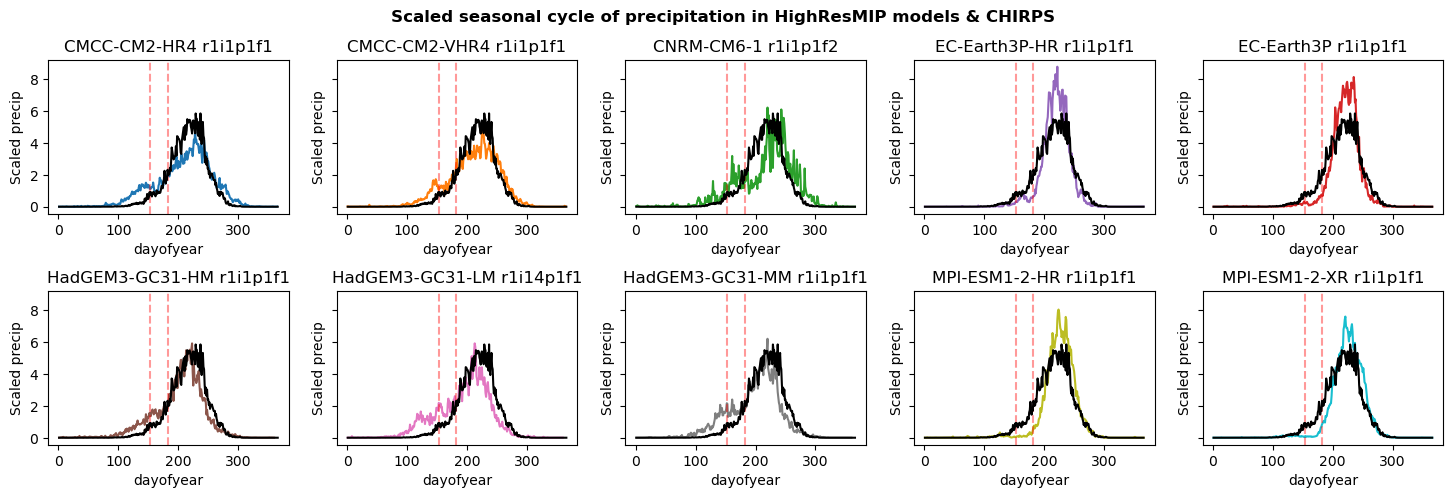

In [19]:
fig, axs = plt.subplots(ncols = 5, nrows = 2, figsize = (18,5), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.5)

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    run = fnm.split("_")[2]+" "+fnm.split("_")[4]
    
    pr = xr.open_dataset(fnm).pr.sel(time = slice("19800101", "20220101"))
    (pr.groupby("time.dayofyear").mean() / pr.mean()).plot(label = run, color = mdl_cols[run], ax = ax)
    
    (chirps.groupby("time.dayofyear").mean() / chirps.mean()).plot(label = "CHIRPS", color = "k", zorder = 100, ax = ax)
    [ax.axvline(d, ls = "--", color = "red", alpha = 0.4) for d in chirps.sel(time = ["20000601", "20000630"]).time.dt.dayofyear.values]
    ax.set_title(run)
    
    ax.set_ylabel("Scaled precip")

plt.suptitle("Scaled seasonal cycle of precipitation in HighResMIP models & CHIRPS", fontweight = "bold")

plt.savefig("HighResMIP-seasonal-cycles-scaled.png")

### **Check spatial patterns**

In [3]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("HighResMIP/pr_spatial_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 3.5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    xr.open_dataset(fnm).pr.sel(month = m).plot(ax = ax, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
    
plt.suptitle("Spatial patterns of June precipitation in wider region", fontweight = "bold", y = 0.9)

plt.savefig("HighResMIP-spatial-patterns-northern-Africa.png")

In [ ]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("HighResMIP/pr_spatial_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 2), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m, lat = slice(13,17), lon = slice(-4,25)).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    xr.open_dataset(fnm).pr.sel(month = m, lat = slice(13,17), lon = slice(-4,25)).plot(ax = ax, **plot_kwargs)
    ax.set_title(fnm.split("_")[2]+" "+fnm.split("_")[4])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")

plt.suptitle("Spatial patterns of June precipitation in study region", fontweight = "bold", y = 0.9)
    
plt.savefig("HighResMIP-spatial-patterns-study-region.png")

### **Time series of indices**

In [14]:
# loop over all available data & compute annual time series

hr_june_totals = []; hr_onsets = []; hr_ends = []; hr_durations = []

for fnm in fl:
    
    mdl = fnm.split("_")[2]+" "+fnm.split("_")[4]

    # exclude any runs already flagged as low quality based on seasonal cycle / spatial pattern
    # if mdl in omit: continue
    
    pr = xr.open_dataset(fnm).pr.expand_dims(run = [mdl]).sel(time = slice("19500101", "20510101"))
    
    jt = jun_total(pr)
    hr_june_totals.append(jt)
    
    os, end, dur = rainy_season(pr)
    hr_onsets.append(os); hr_ends.append(end); hr_durations.append(dur)
    
    # save files as .txt for direct import into climate explorer
    [cx_csv(da) for da in [jt, os, dur]]
    
hr_june_totals, hr_onsets, hr_ends, hr_durations = [xr.concat(l, "run") for l in [hr_june_totals, hr_onsets, hr_ends, hr_durations]]

# also save as single netcdf containing all runs for each index
hr_june_totals.to_netcdf("ts/june_totals-highresmip.nc")
hr_onsets.to_netcdf("ts/season_onsets-highresmip.nc")
hr_ends.to_netcdf("ts/season_ends-highresmip.nc")
hr_durations.to_netcdf("ts/season_durations-highresmip.nc")

Text(0.5, 0.98, 'Time series of indices in HighResMIP models and CHIRPS')

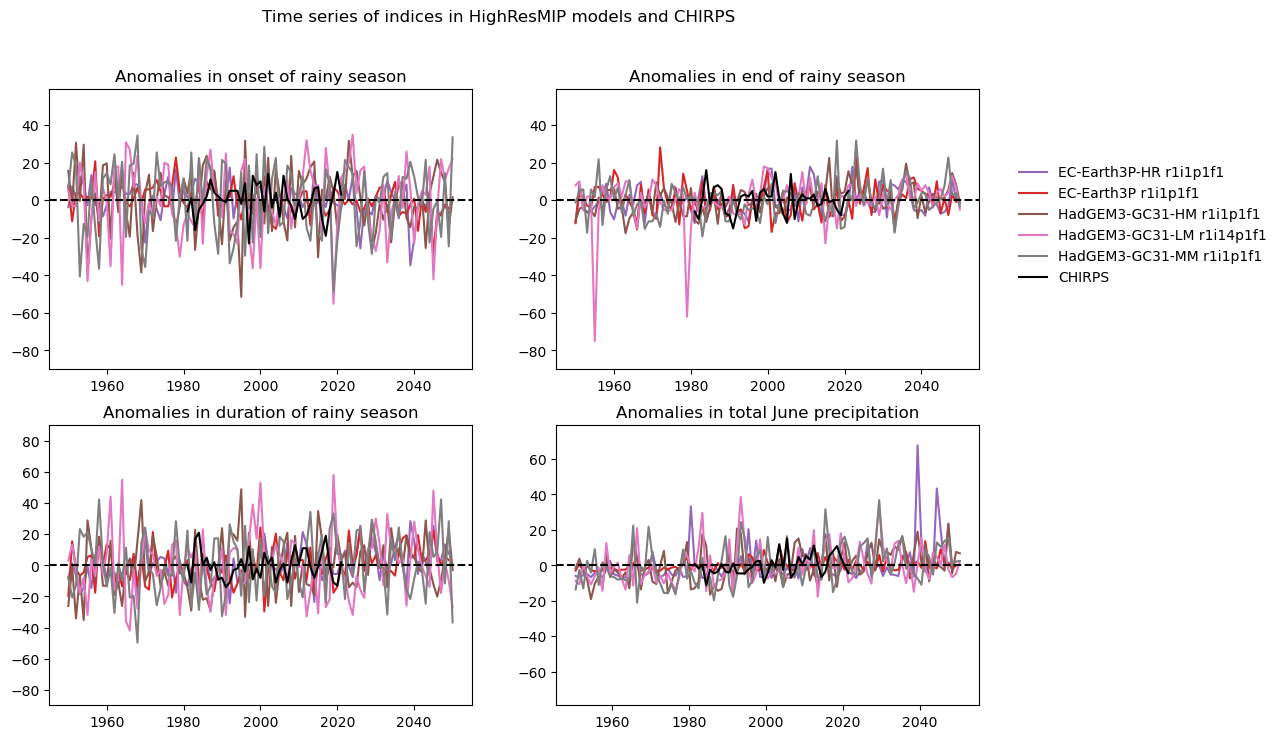

In [16]:
# plot time series

fig, axs = plt.subplots(ncols = 2, nrows = 2, figsize = (12,8), dpi = 100, facecolor = "w")

for mdl in hr_onsets.run.values:

    if mdl in omit: continue
    c = mdl_cols[mdl]
    
    axs[0,0].plot(hr_onsets.year, (hr_onsets - hr_onsets.mean("year")).sel(run = mdl), color = c, label = mdl)
    axs[0,1].plot(hr_ends.year, (hr_ends - hr_ends.mean("year")).sel(run = mdl), color = c)
    axs[1,0].plot(hr_durations.year, (hr_durations - hr_durations.mean("year")).sel(run = mdl), color = c)
    axs[1,1].plot(hr_june_totals.time, (hr_june_totals - hr_june_totals.mean("time")).sel(run = mdl), color = c)

axs[0,0].set_title("Anomalies in onset of rainy season")
axs[0,0].set_ylim(-90,59)
axs[0,0].plot(onsets.year, onsets - onsets.mean("year"), color = "k", label = "CHIRPS")

axs[0,1].set_title("Anomalies in end of rainy season")
axs[0,1].set_ylim(-90,59)
axs[0,1].plot(ends.year, ends - ends.mean("year"), color = "k")

axs[1,0].set_title("Anomalies in duration of rainy season")
axs[1,0].set_ylim(-90,90)
axs[1,0].plot(durations.year, durations - durations.mean("year"), color = "k")

axs[1,1].set_title("Anomalies in total June precipitation")
axs[1,1].set_ylim(-79,79)
axs[1,1].plot(june_totals.time, june_totals - june_totals.mean("time"), color = "k")

for ax in fig.axes: ax.axhline(0, ls = "--", color = "k")
fig.legend(bbox_to_anchor = (1.15,0.8), edgecolor = "w")

plt.suptitle("Time series of indices in HighResMIP models and CHIRPS")

---
### **Check model fit**

In [7]:
def density_plots(model_data, obs_data, ax = None):
    
    if ax is None:
        fig, axs = plt.subplots(ncols = 1, figsize = (6,4), dpi = 100)
        
    pd.DataFrame(obs_data.values, columns = ["CHIRPS"]).plot.density(ax = axs, color = "k", zorder = 100)
    
    for rnm in model_data.run.values:
        pd.DataFrame(model_data.sel(run = rnm).values, columns = [rnm]).plot.density(ax = axs, color = mdl_cols[rnm])
        
    plt.legend(edgecolor = "w")
    

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
def compare_qq(model_data, obs_data):
    
    fig, axs = plt.subplots(ncols = 2, figsize = (10,4), dpi = 100)
    
    qqplot(obs_data, ax = axs[0], label = "CHIRPS", color = "k", zorder = 100)
    qqplot(obs_data, ax = axs[1], color = "k", dist = gamma, zorder = 100)
    
    for rnm in model_data.run.values:
        
        qqplot(model_data.sel(run = rnm), ax = axs[0], label = rnm, color = mdl_cols[rnm])
        qqplot(model_data.sel(run = rnm), dist = gamma, ax = axs[1], color = mdl_cols[rnm])
        
    axs[0].set_title("Normal Q-Q plot")
    axs[1].set_title("Gamma Q-Q plot")
    
    fig.legend(edgecolor = "w", bbox_to_anchor = (0.9,0.8), loc = "upper left")

#### **Total June precipitation**

(0.0, 120.30643326044083)

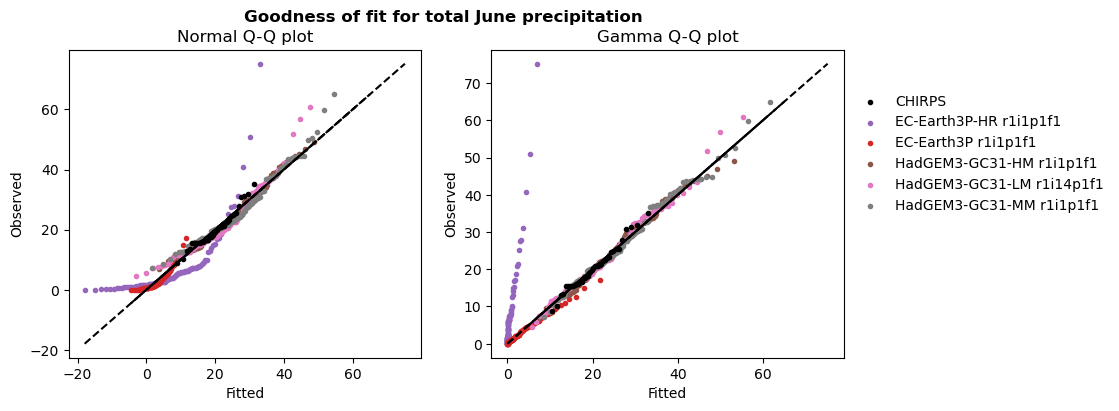

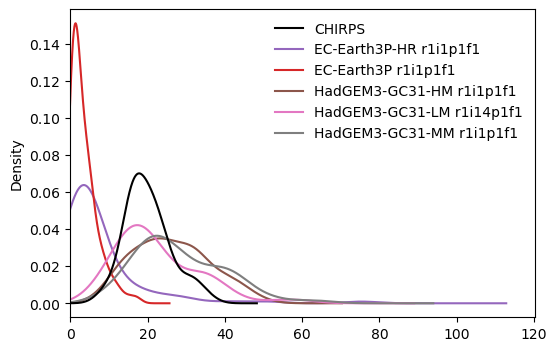

In [8]:
june_totals = xr.open_dataset("ts/june_totals-chirps.nc").june_total
hr_june_totals = xr.open_dataset("ts/june_totals-highresmip.nc").june_total

compare_qq(hr_june_totals, june_totals)
plt.suptitle('Goodness of fit for total June precipitation', fontweight = "bold")

density_plots(hr_june_totals, june_totals)
plt.gcf().axes[0].set_xlim(0)

#### **Onset of rainy season**

In [ ]:
hr_onsets = xr.open_dataset("ts/season_onsets-highresmip.nc").rs_onset
onsets = xr.open_dataset("ts/season_onsets-chirps.nc").rs_onset

compare_qq(hr_onsets, onsets)
plt.suptitle('Goodness of fit for onset of rainy season', fontweight = "bold")

density_plots(hr_onsets, onsets)
plt.gcf().axes[0].set_xlim(0)
plt.legend(bbox_to_anchor = (1,0.8), edgecolor = "w")

#### **Duration of rainy season**

In [ ]:
hr_durations = xr.open_dataset("ts/season_durations-highresmip.nc").rs_duration
durations = xr.open_dataset("ts/season_durations-chirps.nc").rs_duration

compare_qq(hr_durations, durations)
plt.suptitle('Goodness of fit for duration of rainy season', fontweight = "bold")

density_plots(hr_durations, durations)
plt.gcf().axes[0].set_xlim(0)
plt.legend(bbox_to_anchor = (1,0.8), edgecolor = "w")

---
## **CORDEX: AFR-44**

In [21]:
# create fixed colour scheme for plotting (ensures same colour per run regardless of models omitted)
fl = sorted(glob.glob("cordex/pr_AFR-44_*.nc"))
mdl_cols = dict(zip(sorted([fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5] for fnm in fl]), matplotlib.cm.get_cmap('tab20')(np.arange(0,1,1/len(fl)))))

In [3]:
# models excluded on basis of seasonal cycle
omit = []

### **Check seasonal cycle**

In [4]:
# load observations for reference
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any").sel(time = slice(None, "20211231"))
june_totals = jun_total(chirps)
onsets, ends, durations = rainy_season(chirps)

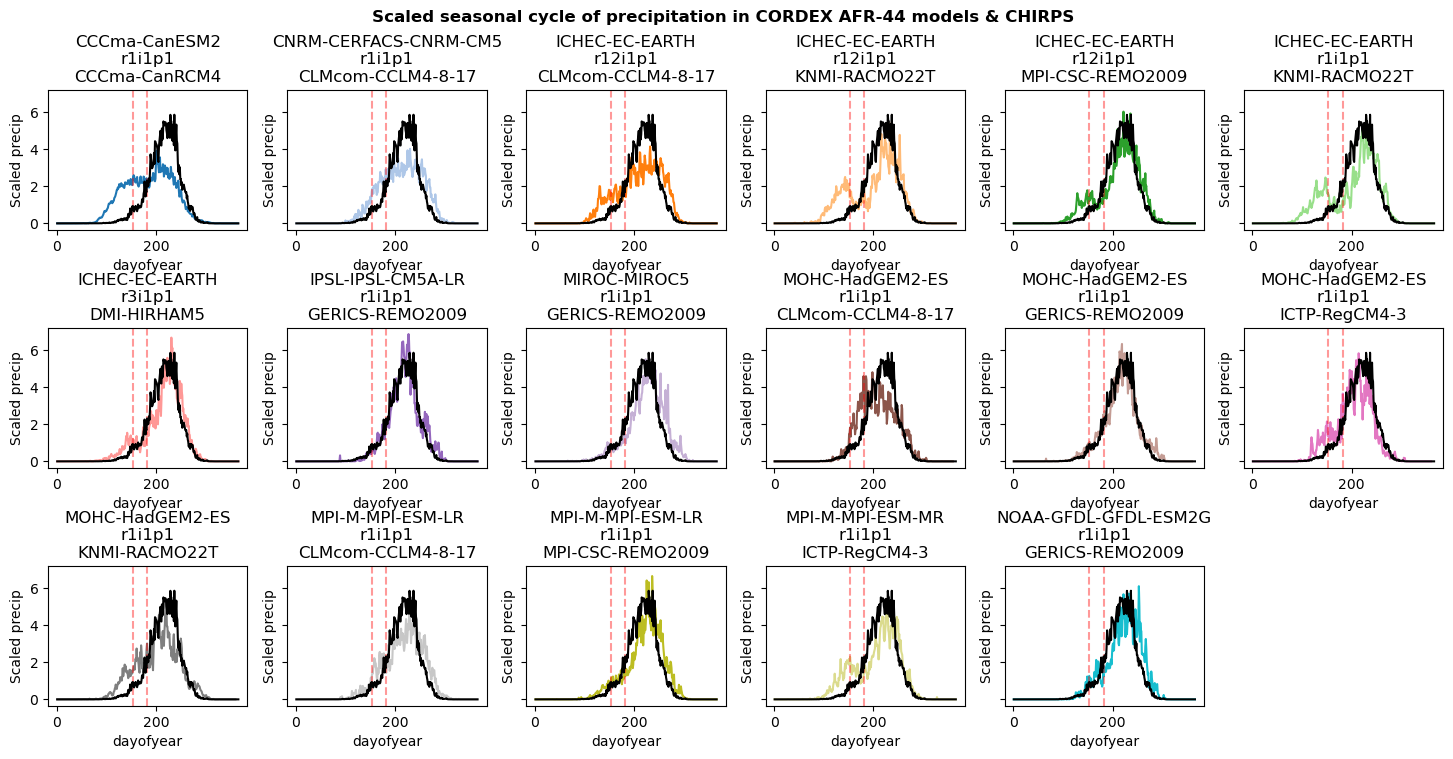

In [23]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (18,8), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.7)

for ax in fig.axes: ax.set_axis_off()

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    run = fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5]
    
    pr = xr.open_dataset(fnm).pr.sel(time = slice("19800101", "20220101"))
    (pr.groupby("time.dayofyear").mean() / pr.mean()).plot(label = run, color = mdl_cols[run], ax = ax)
    
    (chirps.groupby("time.dayofyear").mean() / chirps.mean()).plot(label = "CHIRPS", color = "k", zorder = 100, ax = ax)
    [ax.axvline(d, ls = "--", color = "red", alpha = 0.4) for d in chirps.sel(time = ["20000601", "20000630"]).time.dt.dayofyear.values]
    ax.set_title(run)
    
    ax.set_ylabel("Scaled precip")
    ax.set_axis_on()

plt.suptitle("Scaled seasonal cycle of precipitation in CORDEX AFR-44 models & CHIRPS", fontweight = "bold")

plt.savefig("AFR44-seasonal-cycles-scaled.png")

### **Check spatial patterns**

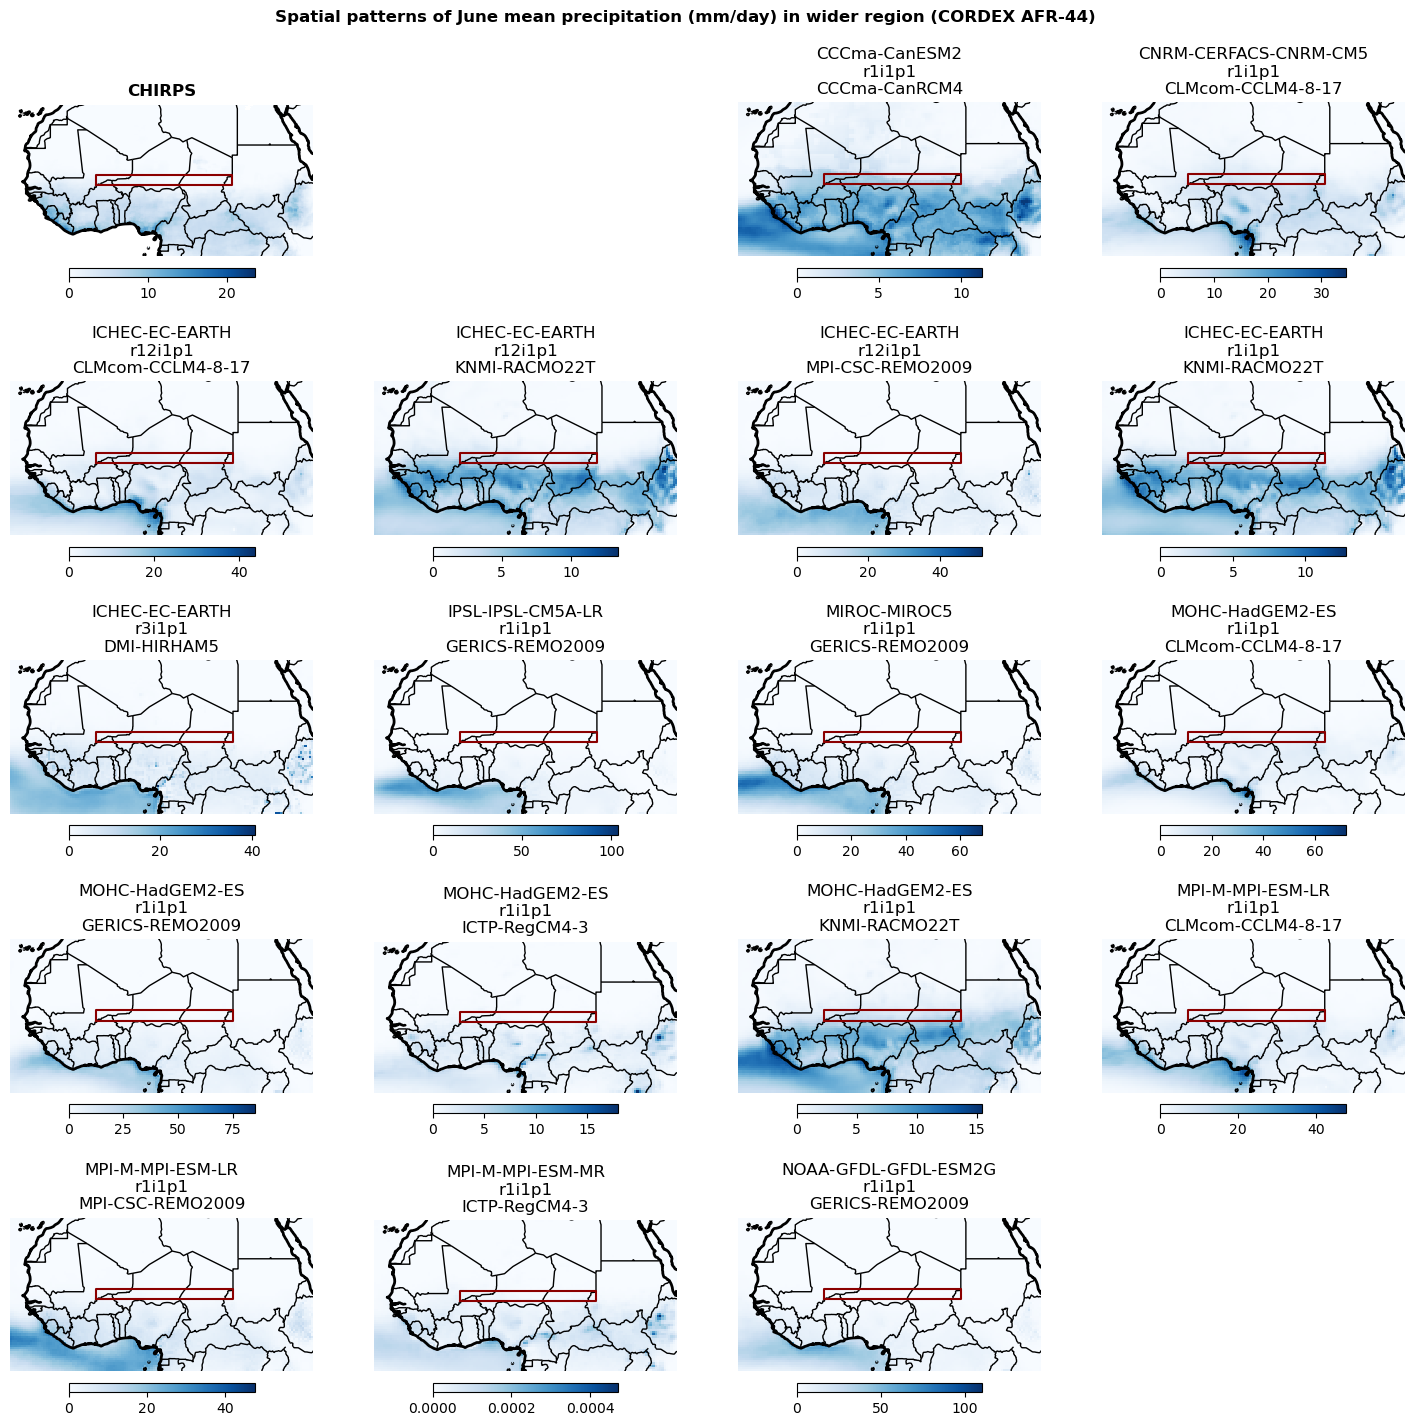

In [34]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("cordex/pr-spatial_AFR-44_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 3.5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "label" : ""}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    pr = xr.open_dataset(fnm).pr.sel(month = m)
    
    if "RegCM" in fnm:
        cbar = ax.pcolormesh(pr.lon, pr.lat, pr, cmap = "Blues", vmin = 0)
        plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.04, pad = 0.05)
    else:
        pr.plot(ax = ax, **plot_kwargs)
        
    ax.set_title(fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
    
plt.suptitle("Spatial patterns of June mean precipitation (mm/day) in wider region (CORDEX AFR-44)", fontweight = "bold", y = 0.9)

plt.savefig("AFR44-spatial-patterns-northern-Africa.png")

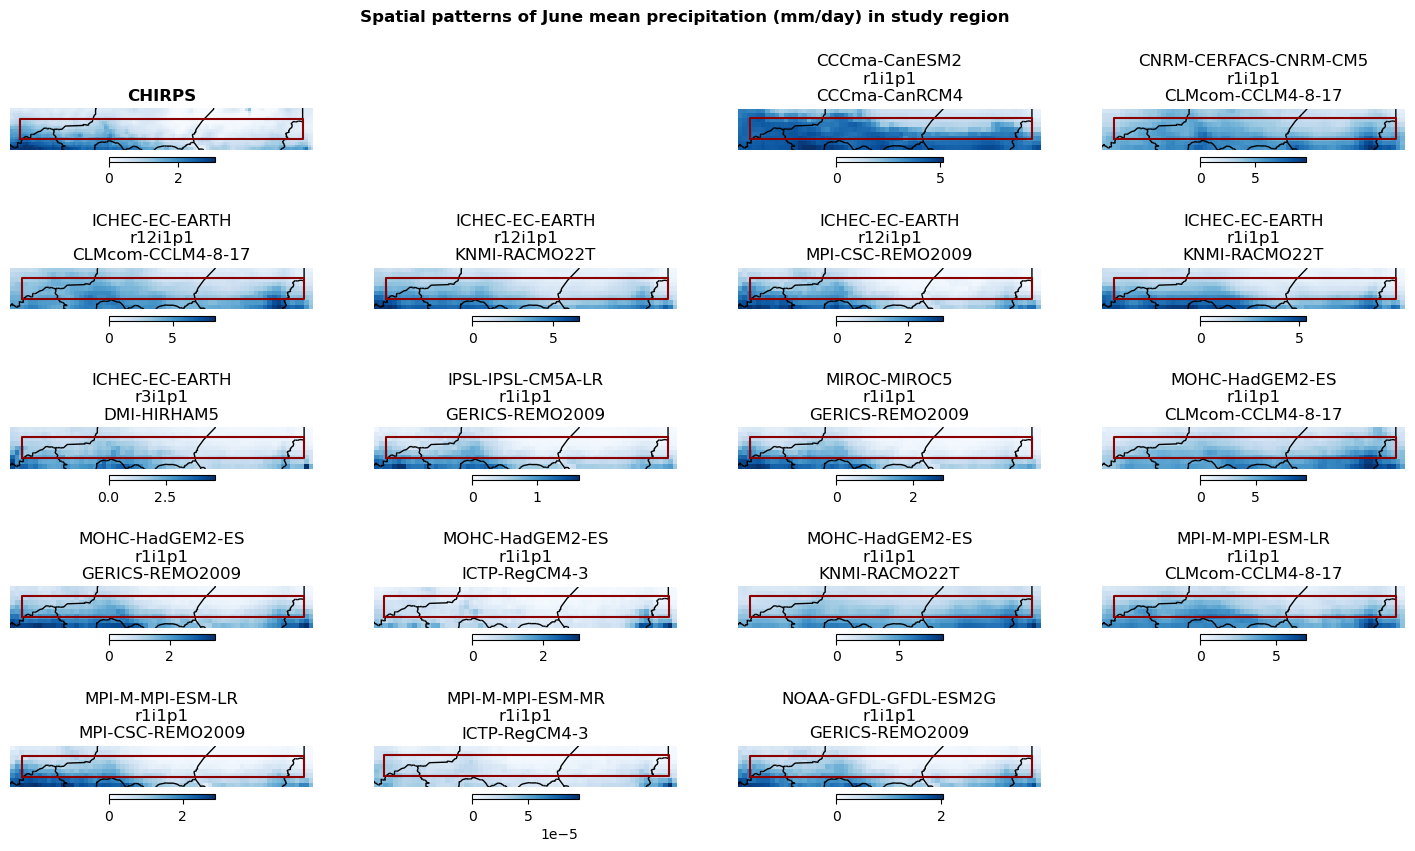

In [32]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("cordex/pr-spatial_AFR-44_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 2), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "label" : ""}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m, lat = slice(13,17), lon = slice(-4,25)).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    pr = xr.open_dataset(fnm).pr.sel(month = m)
    
    if "x" in pr.dims:
        pr_sr = pr.sel(y = [lat >= 13 and lat <= 17 for lat in pr.lat.mean("x").values],
                       x = [lon >= -4 and lon <= 25 for lon in pr.lon.mean("y").values])
        cbar = ax.pcolormesh(pr_sr.lon, pr_sr.lat, pr_sr, cmap = "Blues", vmin = 0)
        plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.04, pad = 0.05)
    else:
        pr.sel(rlat = [lat >= 13 and lat <= 17 for lat in pr.lat.mean("rlon").values],
               rlon = [lon >= -4 and lon <= 25 for lon in pr.lon.mean("rlat").values]).plot(ax = ax, **plot_kwargs)
        
    ax.set_title(fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
    
plt.suptitle("Spatial patterns of June mean precipitation (mm/day) in study region (CORDEX AFR-44)", fontweight = "bold", y = 0.9)

plt.savefig("AFR44-spatial-patterns-study-region.png")

### **Time series of indices**

In [60]:
# loop over all available data & compute annual time series

hr_june_totals = []; hr_onsets = []; hr_ends = []; hr_durations = []

fl = sorted(glob.glob("cordex/pr_AFR-44_*.nc"))
for fnm in fl:
    
    mdl = fnm.split("_")[2]+" "+fnm.split("_")[4]+" "+fnm.split("_")[5]

    # exclude any runs already flagged as low quality based on seasonal cycle / spatial pattern
    # if mdl in omit: continue
    
    pr = xr.open_dataset(fnm).pr.expand_dims(run = [mdl]).sel(time = slice("19500101", "20510101"))
    
    jt = jun_total(pr)
    hr_june_totals.append(jt)
    
    os, end, dur = rainy_season(pr)
    hr_onsets.append(os); hr_ends.append(end); hr_durations.append(dur)
    
    # save files as .txt for direct import into climate explorer
    [cx_csv(da, dataset = "AFR-44") for da in [jt, os, dur]]
    
hr_june_totals, hr_onsets, hr_ends, hr_durations = [xr.concat(l, "run") for l in [hr_june_totals, hr_onsets, hr_ends, hr_durations]]

# also save as single netcdf containing all runs for each index
hr_june_totals.to_netcdf("ts/june_totals-afr44.nc")
hr_onsets.to_netcdf("ts/season_onsets-afr44.nc")
hr_ends.to_netcdf("ts/season_ends-afr44.nc")
hr_durations.to_netcdf("ts/season_durations-afr44.nc")

---
## **CORDEX: AFR-22**

In [52]:
# create fixed colour scheme for plotting (ensures same colour per run regardless of models omitted)
fl = sorted(glob.glob("cordex/pr_AFR-22_*.nc"))
mdl_cols = dict(zip(sorted([fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5] for fnm in fl]), matplotlib.cm.get_cmap('tab20')(np.arange(0,1,1/len(fl)))))

# models excluded on basis of seasonal cycle
omit = ['cordex/pr_AFR-22_CCCma-CanESM2_historical_r1i1p1_CCCma-CanRCM4_r2_day_19500101-21001231.nc'] # doesn't actually contain any data

fl = [fnm for fnm in fl if not fnm in omit]

### **Check seasonal cycle**

In [39]:
# load observations for reference
chirps = xr.open_dataset("obs/ichirps_20_25_-3-24E_14-16N_n.nc").precip.dropna("time", "any").sel(time = slice(None, "20211231"))
june_totals = jun_total(chirps)
onsets, ends, durations = rainy_season(chirps)

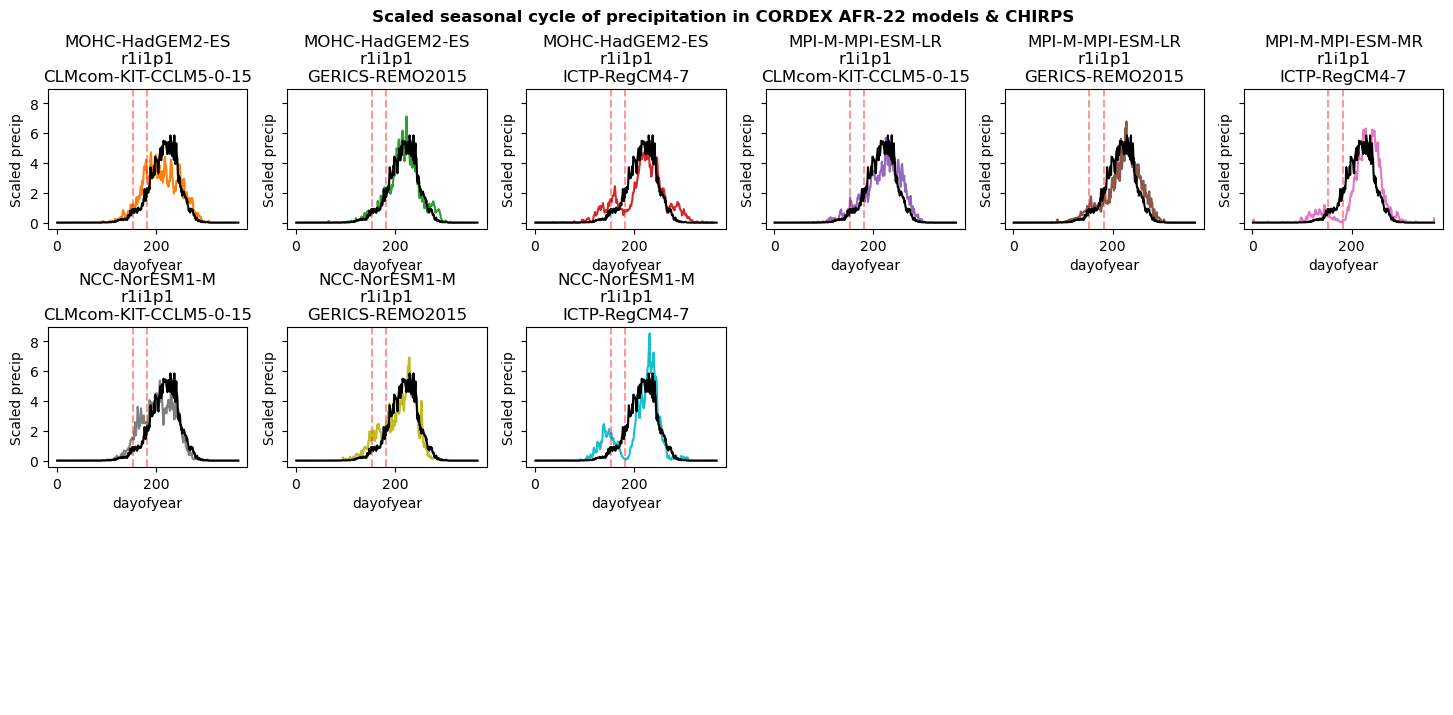

In [56]:
fig, axs = plt.subplots(ncols = 6, nrows = 3, figsize = (18,8), dpi = 100, sharey = True)
plt.subplots_adjust(hspace = 0.7)

for ax in fig.axes: ax.set_axis_off()

for i in range(len(fl)):
    
    ax = fig.axes[i]
    fnm = fl[i]
    run = fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5]
    
    pr = xr.open_dataset(fnm).pr.sel(time = slice("19800101", "20220101"))
    (pr.groupby("time.dayofyear").mean() / pr.mean()).plot(label = run, color = mdl_cols[run], ax = ax)
    
    (chirps.groupby("time.dayofyear").mean() / chirps.mean()).plot(label = "CHIRPS", color = "k", zorder = 100, ax = ax)
    [ax.axvline(d, ls = "--", color = "red", alpha = 0.4) for d in chirps.sel(time = ["20000601", "20000630"]).time.dt.dayofyear.values]
    ax.set_title(run)
    
    ax.set_ylabel("Scaled precip")
    ax.set_axis_on()

plt.suptitle("Scaled seasonal cycle of precipitation in CORDEX AFR-22 models & CHIRPS", fontweight = "bold")

plt.savefig("AFR22-seasonal-cycles-scaled.png")

### **Check spatial patterns**

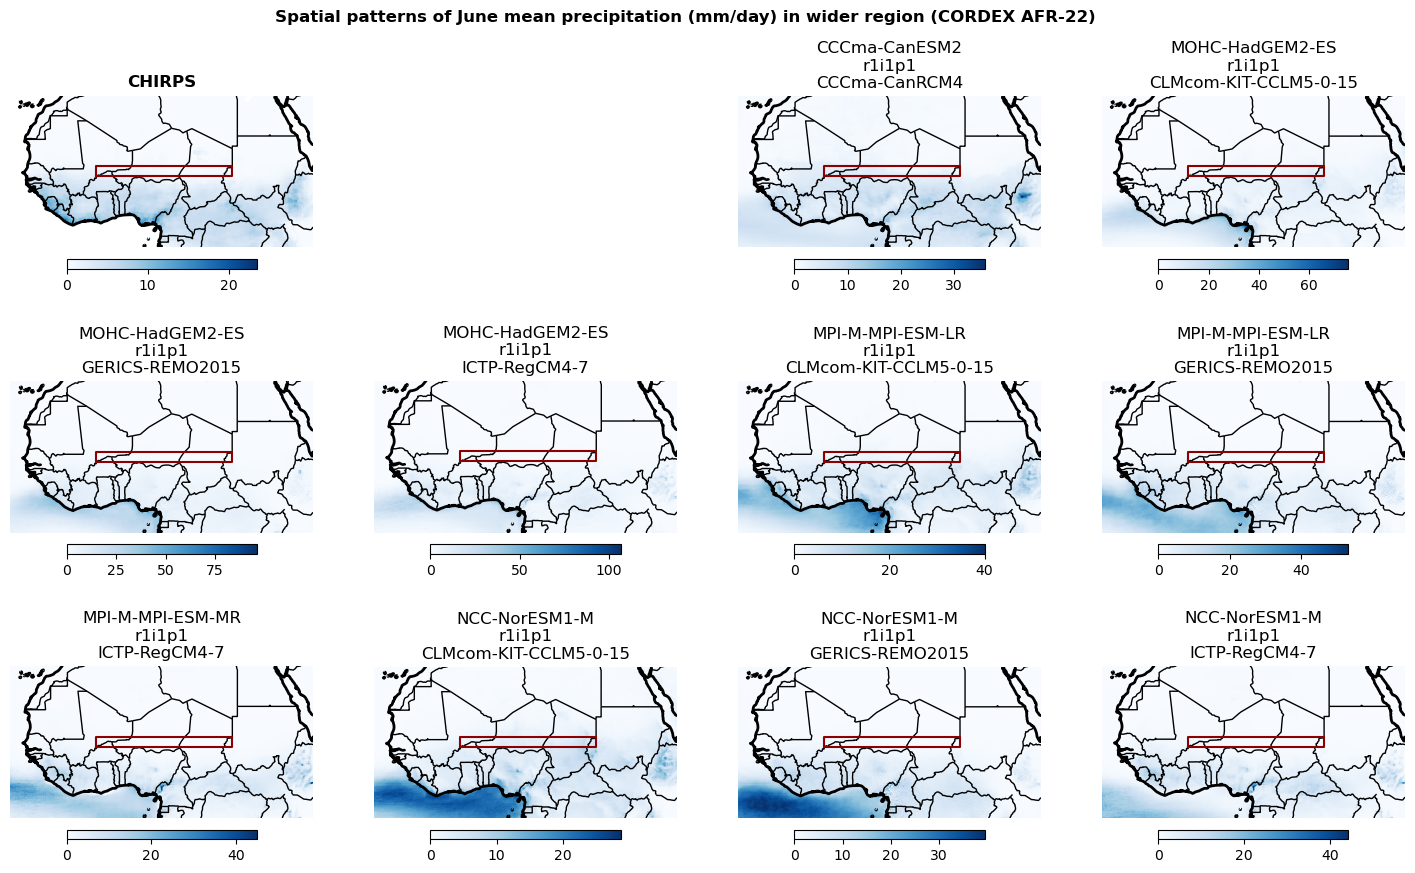

In [49]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("cordex/pr-spatial_AFR-22_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 3.5), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "label" : ""}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    pr = xr.open_dataset(fnm).pr.sel(month = m)
    
    if "RegCM" in fnm:
        cbar = ax.pcolormesh(pr.lon, pr.lat, pr, cmap = "Blues", vmin = 0)
        plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.04, pad = 0.05)
    else:
        pr.plot(ax = ax, **plot_kwargs)
        
    ax.set_title(fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
    
plt.suptitle("Spatial patterns of June mean precipitation (mm/day) in wider region (CORDEX AFR-22)", fontweight = "bold", y = 0.9)

plt.savefig("AFR22-spatial-patterns-northern-Africa.png")

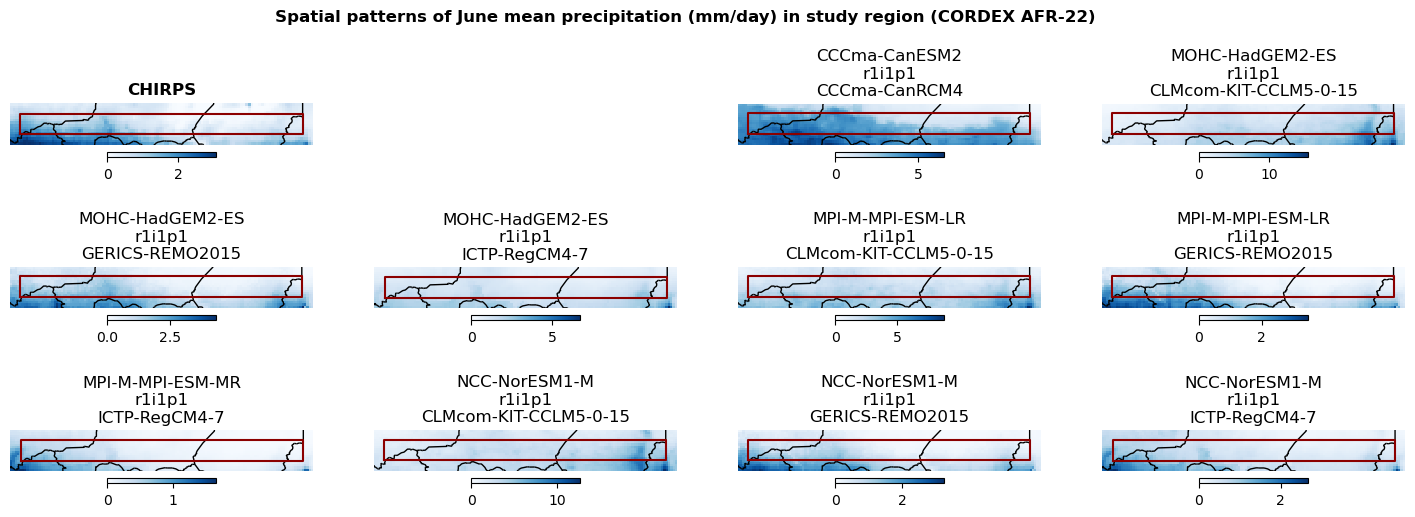

In [33]:
m = 6

chirps_sp = xr.open_dataset("obs/v2p0chirps_25_-20-40E_0-30N.62f4b5a82fde776a4c64f0ca33646aa0.info_12_mean_30.nc", decode_times=False).precip
startdate = pd.Timestamp('1981-01-01 00:00:00.000000').to_pydatetime()
chirps_sp = chirps_sp.assign_coords(time = [np.datetime64(startdate + relativedelta(months = i)) for i in range(len(chirps_sp.time))])
chirps_sp = chirps_sp.groupby("time.month").mean("time")

fl_sp = sorted(glob.glob("cordex/pr-spatial_AFR-22_*.nc"))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

nr = int(np.ceil((len(fl_sp)+2) / 4))
fig, axs = plt.subplots(ncols = 4, nrows = nr, figsize = (18, (nr) * 2), dpi = 100, subplot_kw = {"projection" : cartopy.crs.PlateCarree()})

plot_kwargs = {"add_colorbar" : True, "cbar_kwargs" : {"location" : "bottom", "fraction" : 0.04, "pad" : 0.05, "label" : ""}, "cmap" : "Blues", "vmin" : 0}

for ax in fig.axes: ax.set_axis_off()

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# CHIRPS data for reference
ax = fig.axes[0]
chirps_sp.sel(month = m, lat = slice(13,17), lon = slice(-4,25)).plot(ax = ax, **plot_kwargs)
ax.coastlines(lw = 2)
ax.add_feature(cartopy.feature.BORDERS)
ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
ax.set_title("CHIRPS", fontweight = "bold")

# models
for i in range(len(fl_sp)):
    
    fnm = fl_sp[i]
    ax = fig.axes[i+2]
    
    pr = xr.open_dataset(fnm).pr.sel(month = m)
    
    if "x" in pr.dims:
        pr_sr = pr.sel(y = [lat >= 13 and lat <= 17 for lat in pr.lat.mean("x").values],
                       x = [lon >= -4 and lon <= 25 for lon in pr.lon.mean("y").values])
        cbar = ax.pcolormesh(pr_sr.lon, pr_sr.lat, pr_sr, cmap = "Blues", vmin = 0)
        plt.colorbar(cbar, ax = ax, location = "bottom", fraction = 0.04, pad = 0.05)
    else:
        pr.sel(rlat = [lat >= 13 and lat <= 17 for lat in pr.lat.mean("rlon").values],
               rlon = [lon >= -4 and lon <= 25 for lon in pr.lon.mean("rlat").values]).plot(ax = ax, **plot_kwargs)
        
    ax.set_title(fnm.split("_")[2]+"\n"+fnm.split("_")[4]+"\n"+fnm.split("_")[5])
    
    ax.coastlines(lw = 2)
    ax.add_feature(cartopy.feature.BORDERS)
    ax.plot([-3,24,24,-3,-3], [14,14,16,16,14], color = "darkred")
    
plt.suptitle("Spatial patterns of June mean precipitation (mm/day) in study region (CORDEX AFR-22)", fontweight = "bold", y = 0.9)

plt.savefig("AFR22-spatial-patterns-study-region.png")

### **Time series of indices**

In [61]:
# loop over all available data & compute annual time series

hr_june_totals = []; hr_onsets = []; hr_ends = []; hr_durations = []

fl = sorted(glob.glob("cordex/pr_AFR-22_*.nc"))
for fnm in fl:
    
    if "CanESM" in fnm: continue     # damaged file, contains no data
    
    mdl = fnm.split("_")[2]+" "+fnm.split("_")[4]+" "+fnm.split("_")[5]

    # exclude any runs already flagged as low quality based on seasonal cycle / spatial pattern
    # if mdl in omit: continue
    
    pr = xr.open_dataset(fnm).pr.expand_dims(run = [mdl]).sel(time = slice("19500101", "20510101"))
    
    jt = jun_total(pr)
    hr_june_totals.append(jt)
    
    os, end, dur = rainy_season(pr)
    hr_onsets.append(os); hr_ends.append(end); hr_durations.append(dur)
    
    # save files as .txt for direct import into climate explorer
    [cx_csv(da, dataset = "AFR-22") for da in [jt, os, dur]]
    
hr_june_totals, hr_onsets, hr_ends, hr_durations = [xr.concat(l, "run") for l in [hr_june_totals, hr_onsets, hr_ends, hr_durations]]

# also save as single netcdf containing all runs for each index
hr_june_totals.to_netcdf("ts/june_totals-afr22.nc")
hr_onsets.to_netcdf("ts/season_onsets-afr22.nc")
hr_ends.to_netcdf("ts/season_ends-afr22.nc")
hr_durations.to_netcdf("ts/season_durations-afr22.nc")

---
## **Parameter validation**

In [ ]:
jun = pd.read_csv("june-precip.csv", skiprows = 2)
dur = pd.read_csv("rs-duration.csv", skiprows = 2)
onset = pd.read_csv("rs-onset.csv", skiprows = 2)

#### **June precipitation - validation vs attribution in HighResMIP models**

In [ ]:
fig, axs = plt.subplots(ncols = 5, figsize = (20,3), dpi = 100, facecolor = "w")

for mdl in jun.loc[jun.source == "validation"].dataset.tolist():
    
    v = jun.loc[(jun.dataset == mdl) & (jun.source == "validation")]
    a = jun.loc[(jun.dataset == mdl) & (jun.source == "attribution")]
    
    axs[0].plot(a[["sigma_lb", "sigma", "sigma_ub"]].values, np.repeat(0.1,3) )
    

In [ ]:
sorted(glob.glob("HighResMIP/*"))

In [ ]:
a[["sigma_lb", "sigma", "sigma_ub"]]